In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [159]:
import glob
import random
import os
import numpy as np
import torch

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import videotransforms

"""
Modify ActionRecognition's code
"""
class UCF101Dataset(Dataset):
    def __init__(self, dataset_path, split_path, split_number, input_shape, sequence_length, training, test_random=False):
        self.training = training
        self.test_random = test_random
        self.label_index = self._extract_label_mapping(split_path)
        self.sequences = self._extract_sequence_paths(dataset_path, split_path, split_number, training)
        self.sequence_length = sequence_length
        self.label_names = sorted(list(set([self._activity_from_path(seq_path) for seq_path in self.sequences])))
        self.num_classes = len(self.label_names)

#         if self.training:
#             self.transform = transforms.Compose(
#                 [
#                     transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
#                     transforms.RandomCrop(224),
#                     transforms.ToTensor(),
#                     transforms.Normalize(mean, std),
#                 ]
#             )
#         else:
#             self.transform = transforms.Compose(
#                 [
#                     transforms.Resize(224, transforms.InterpolationMode.BICUBIC),
#                     transforms.CenterCrop(224),
#                     transforms.ToTensor(),
#                     transforms.Normalize(mean, std),
#                 ]
#             )
    
    def transform(self, images):
        # Normalization parameters for pre-trained I3D models
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        
        if self.training:
            resize_size = 256
            resize = transforms.Resize(resize_size, transforms.InterpolationMode.BICUBIC)
            crop = transforms.RandomCrop(224)
            i, j, h, w = crop.get_params(images[0], (224, 224))
            totensor = transforms.ToTensor()
            normalize = transforms.Normalize(mean, std)

            images_transform = []
            for image in images:
                image = resize(image)
                image = F.crop(image, i, j, h, w)
                image = totensor(image)
                image = normalize(image)
                images_transform.append(image)
        else:
            resize_size = 224
            resize = transforms.Resize(resize_size, transforms.InterpolationMode.BICUBIC)
            crop = transforms.CenterCrop(224)
            totensor = transforms.ToTensor()
            normalize = transforms.Normalize(mean, std)

            images_transform = []
            for image in images:
                image = resize(image)
                image = crop(image)
                image = totensor(image)
                image = normalize(image)
                images_transform.append(image)
        # convert (T, C, W, H) --> (C, T, W, H)
        images_transform = torch.stack(images_transform).permute(1,0,2,3)
        
        return images_transform

    def _extract_label_mapping(self, split_path="data/ucfTrainTestlist"):
        """ Extracts a mapping between activity name and softmax index """
        with open(os.path.join(split_path, "classInd.txt")) as file:
            lines = file.read().splitlines()
        label_mapping = {}
        for line in lines:
            label, action = line.split()
            label_mapping[action] = int(label) - 1
        return label_mapping

    def _extract_sequence_paths(
        self, dataset_path, split_path="data/ucfTrainTestlist", split_number=1, training=True
    ):
        """ Extracts paths to sequences given the specified train / test split """
        assert split_number in [1, 2, 3], "Split number has to be one of {1, 2, 3}"
        fn = f"trainlist0{split_number}.txt" if training else f"testlist0{split_number}.txt"
        split_path = os.path.join(split_path, fn)
        with open(split_path) as file:
            lines = file.read().splitlines()
        sequence_paths = []
        for line in lines:
            seq_name = line.split(".avi")[0]
            sequence_paths += [os.path.join(dataset_path, seq_name)]
        return sequence_paths

    def _activity_from_path(self, path):
        """ Extracts activity name from filepath """
        return path.split("/")[-2]

    def _frame_number(self, image_path):
        """ Extracts frame number from filepath """
        return int(image_path.split("/")[-1].split(".jpg")[0])

    def _pad_to_length(self, sequence):
        """ Pads the sequence to required sequence length """
        left_pad = sequence[0]
        if self.sequence_length is not None:
            while len(sequence) < self.sequence_length:
                sequence.insert(0, left_pad)
        return sequence

    def __getitem__(self, index):
        sequence_path = self.sequences[index % len(self)]
        # Sort frame sequence based on frame number
        image_paths = sorted(glob.glob(f"{sequence_path}/*.jpg"), key=lambda path: self._frame_number(path))
        # Pad frames sequences shorter than `self.sequence_length` to length
        image_paths = self._pad_to_length(image_paths)
        if self.training:
            # Randomly choose sample interval and start frame
            start_i = np.random.randint(0, len(image_paths) - self.sequence_length + 1)
            flip = np.random.random() < 0.5
        else:
            # Start at first frame and sample uniformly over sequence
            start_i = np.random.randint(0, len(image_paths) - self.sequence_length + 1)
            flip = False
            
        # Extract frames as tensors
        image_sequence = []
        for i in range(start_i, start_i+self.sequence_length):
            if self.sequence_length is None or len(image_sequence) < self.sequence_length:
                image = (Image.open(image_paths[i]))
                image_sequence.append(image)
        image_sequence = self.transform(image_sequence)
        
        t = self.label_index[self._activity_from_path(sequence_path)]
        target = torch.nn.functional.one_hot(torch.tensor(t), num_classes=101).repeat((64,1)).permute(1,0)
        return image_sequence, target.float()

    def __len__(self):
        return len(self.sequences)


In [170]:
val_dataset =  UCF101Dataset(
    dataset_path="data/UCF-101-frames",
    split_path="data/ucfTrainTestlist",
    split_number=1,
    input_shape=(3,224,224),
    sequence_length=64,
    training=False,
)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=True, num_workers=1, pin_memory=True)    


In [171]:
for images, labels in val_dataloader:
    break

In [172]:
images = (images + 1) / 2

In [173]:
images.shape

torch.Size([2, 3, 64, 224, 224])

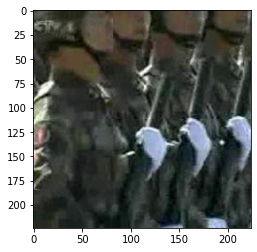

In [176]:
plt.imshow(images[1].permute(1,2,3,0)[0])

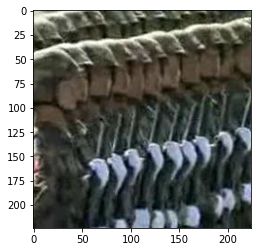

In [178]:
plt.imshow(images[1].permute(1,2,3,0)[50])

In [79]:
crop = transforms.RandomCrop(224)

In [96]:
image = torch.ones(3,256,341)
crop.get_params(image, (224, 224))

(19, 55, 224, 224)

In [104]:
crop.get_params(image, (224, 224))

(28, 95, 224, 224)

In [30]:
ccrop = transforms.CenterCrop(224)

In [31]:
ccrop.get_params(image, (224, 224))

AttributeError: 'CenterCrop' object has no attribute 'get_params'